In [1]:
import pandas as pd
import wget
import os
import lmfit
from lmfit.models import StepModel, ExponentialModel, PolynomialModel, LognormalModel
from lmfit import Parameters, fit_report, minimize


DataSource = 'JohnHopkins'

if DataSource == 'JohnHopkins':
    fname = 'time_series_covid19_confirmed_global.csv'

    if os.path.exists(fname):
        os.remove(fname)

    ddir = 'data/'
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    #'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
    url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    ff = wget.download(url)
    fd = wget.download(url_deaths)
    frec = wget.download(url_recovered)
    print (ff)
    assert ff == fname, f'File name retrieved {ff} changed name? {fname}'

    dd = pd.read_csv(ff)
    deaths = pd.read_csv(fd)
    recovered = pd.read_csv(frec)

else:
    fname = 'full_data.csv'
    if os.path.exists(fname):
        os.remove(fname)
    
    url = 'https://covid.ourworldindata.org/data/ecdc/full_data.csv'
    ff = wget.download(url)
    assert ff == fname, f'File name retrieved {ff} changed name? {fname}'
    dd = pd.read_csv(ff, parse_dates = ['date'])
    
    
## Data source: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series



time_series_covid19_confirmed_global.csv


In [22]:

add_data_manually = False  # to add latest info not in the database yet
countries = ['US']
Yaxis = 'Active' # Cases, Deaths, Active or Recovered

minfit = 100


In [23]:
dd['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

                    Lat     Long  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  \
Country/Region                                                                  
US              37.0902 -95.7129        1        1        2        2        5   

                1/27/20  1/28/20  1/29/20  ...  5/10/20  5/11/20  5/12/20  \
Country/Region                             ...                              
US                    5        5        5  ...  1329260  1347881  1369376   

                5/13/20  5/14/20  5/15/20  5/16/20  5/17/20  5/18/20  5/19/20  
Country/Region                                                                 
US              1390406  1417774  1442824  1467820  1486757  1508308  1528568  

[1 rows x 121 columns]
US 0
US 167
Index(['24/01', '25/01', '26/01', '27/01', '28/01', '29/01', '30/01', '31/01',
       '01/02', '02/02',
       ...
       '29/06', '30/06', '01/07', '02/07', '03/07', '04/07', '05/07', '06/07',
       '07/07', '08/07'],
      dtype='object', length

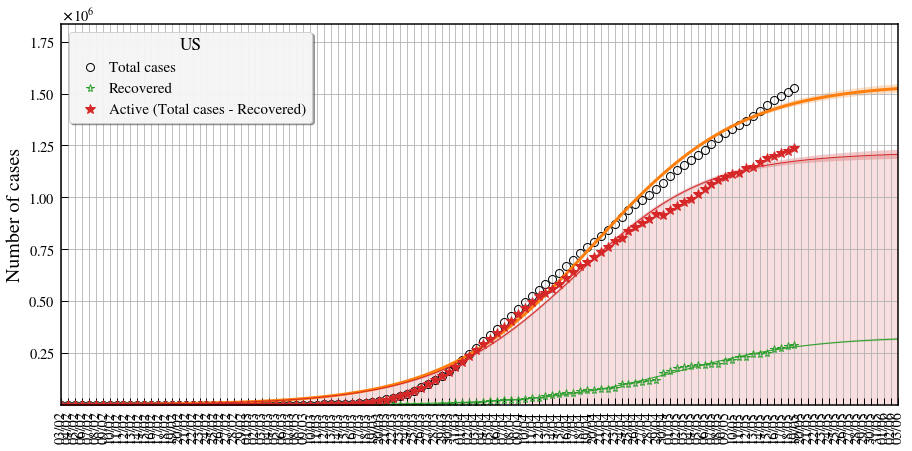

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
#from datetime import Timedelta 
import datetime
from dateutil import parser

timedelta = pd.Timedelta('1 days')

def log2(x, a2, c2, s2):
    aa = (x - c2)/s2
    
    return a2 * (1/(1 - np.exp(-aa)))


ncountries = len(countries)
models= {'Logistic': StepModel(form='logistic'),#, 
        'Exponential': ExponentialModel(),  #,
#        'Double logistic': StepModel(form='logistic') + StepModel(form='logistic')} 
#        'erf': StepModel(form='erf'),
        'Arctan': StepModel(form='atan')}
        #'3th deg. Polynomial': PolynomialModel(degree=3)}
        

        

colors = ['tab:blue','tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
fig, axs = plt.subplots(ncountries,figsize=(15,ncountries*7))
plt.rcParams['legend.title_fontsize'] = 'xx-large'

countryvar = 'location' if DataSource == 'OurWorldData' else 'Country/Region'
covid_dict = {}

for icc,country in enumerate(countries):

    sel = dd[countryvar] == country
    dc = dd.loc[sel].groupby([countryvar]).sum()
    dcd = deaths.loc[deaths[countryvar] == country].groupby([countryvar]).sum()
    drec = recovered.loc[recovered[countryvar] == country].groupby([countryvar]).sum()
    
    print (dc)
    cols = list(dc.columns)
    dates = cols[4:] if DataSource == 'JohnHopkins' else dc['date'].reset_index(drop=True)

    if country == 'xNew Zealand':
        dates = dates - timedelta
    
    if DataSource == 'JohnHopkins':
        nn = []
        nd = []
        nrec = []
        for i in dates:
            nn.append(dc[i].to_numpy()[0])
            nd.append(dcd[i].to_numpy()[0])
            nrec.append(drec[i].to_numpy()[0])
    else:
        nn      = dc['total_cases'].reset_index(drop=True).to_numpy()
        ndeaths = dc['total_deaths'].reset_index(drop=True).to_numpy()
        nnew    = dc['new_cases'].reset_index(drop=True).to_numpy()
        
    xstart = 0
    
    for ii, inn in enumerate(list(nn)):
        if inn > 1:
            xstart = ii-1 if ii > 1 else 0
            break
#    import pdb ; pdb.set_trace()        
    nn = nn[xstart:]
    nd = nd[xstart:]
    nrec = nrec[xstart:]
    
    if DataSource != 'JohnHopkins':
        ndeaths  = ndeaths[xstart:]
        nnew     = nnew[xstart:]
        
    #print (dates.iloc[xstart], xstart)
    if DataSource != 'JohnHopkins':
        dates = dates.iloc[xstart:].reset_index(drop=True)
    else:
        dates = cols[4 + xstart:]
        dates = [parser.parse(x) for x in dates]
    
    # ensuring data completeness
    dates_all = pd.date_range(start=dates[0], end=dates[-1])
    ntotal      = [] #np.zeros(len(dates_all))
    ntot_deaths = []
    ntot_new    = []
    nrecovered  = []
    
    
    iid = 0
    for ixx, idate in enumerate(dates_all):
        if dates[iid] == idate:
            ntotal.append(nn[iid])
            ntot_deaths.append(nd[iid])
            nrecovered.append(nrec[iid])
            #ntot_new.append(nnew[iid])
            iid += 1
        else:
            ntotal.append(ntotal[ixx-1])
            ntot_deaths.append(nd[ixx-1])
            nrecovered.append(nrec[ixx-1])
            #ntot_new.append(ntot_new[ixx-1])
            
    
    #import pdb ; pdb.set_trace()
    
    if add_data_manually:
        if country == 'Chile':
            ntotal.append(2738)
            ntot_deaths.append(ntot_deaths[-1])
            nrecovered.append(nrecovered[-1])
            #ntot_new.append(ntotal[-1] - ntotal[-2])
            dates_all = pd.date_range(start=dates[0], periods = len(dates_all)+1)
        if country == 'New Zealand':
            ntotal.append(1283)
            ntot_deaths.append(ntot_deaths[-1])
            nrecovered.append(nrecovered[-1])
            #ntotal[-2] = 797-89
            #ntot_new.append(ntotal[-1] - ntotal[-2])
            #ntotal.append(589)
            #ntot_deaths.append(0)
            #ntot_new.append(ntotal[-1] - ntotal[-2])
            dates_all = pd.date_range(start=dates[0], periods = len(dates_all)+1)
    
    
    nn = ntot_deaths if Yaxis == 'Deaths' else ntotal
    #if Yaxis == 'Recovered':
    #    nn = nrecovered
        
    dates = dates_all
    xstart = 0
    
    covid_dict[country] = {'dates': dates,
                         'ntotal': ntotal,
                         'ntot_deaths': ntot_deaths,
                          'ntot_new':ntot_new
                         }
    
    print (country, xstart)
    ndata = len(nn)
    nn = np.array(nn)
    xx = np.arange(0,ndata)
    xxx = np.arange(0,ndata+50)
    nper = len(xxx)
    print (country, nper)
    xxxx = np.arange(0,ndata+50)# if nper < 100 else 2)
    datesxxx = pd.date_range(start=dates[0], periods=nper).strftime('%d/%m')
    
    #import pdb ; pdb.set_trace()    
    
    print (datesxxx)
    
    if ncountries > 1:
        ax = axs[icc]
    else:
        ax = axs

    
    ax.set_xticks(xxxx)
    ax.set_xticklabels(datesxxx[xxxx], rotation='vertical')
  #  ax.set_yscale('log')

    icol = 0 
    ixx = np.where(nn > 10)[0] if country == 'Spain' else np.where(nn > minfit)[0]
    bics = []
    mn = []
                

    curve_data = {}
    
    for dfit, dname in zip([nn, nrecovered], ['cases','recovered']):
        curve_data[dname] = {}
        for mname, model in models.items():
            curve_data[dname][mname] = {}
            pars0 = model.guess(np.array(dfit)[ixx], x=xx[ixx])
            out = model.fit(np.array(dfit)[ixx], pars0, x=xx[ixx])

            
            mn.append(mname)

            dely = out.eval_uncertainty(x=xxx)
            y =  out.eval(out.params,x=xxx)
            
            curve_data[dname][mname]['pars'] = out.params
            curve_data[dname][mname]['bic'] = out.bic
            curve_data[dname][mname]['dely'] = dely
            curve_data[dname][mname]['y'] = y
           
            """
            if mname == 'Exponential' or mname == 'Logistic' or mname == 'LogNormal':
                for prev_fit in [-1]:#,-2,-3,-4,-5]:
                    print (prev_fit)
                    pars0 = model.guess(nn[ixx[:prev_fit]], x=xx[ixx[:prev_fit]])
                    out = model.fit(nn[ixx[:prev_fit]], pars0, x=xx[ixx[:prev_fit]])
                    pars = out.params
                    #bics.append(out.bic)
                    #mn.append(mname)

                    #dely = out.eval_uncertainty(x=xxx)
                    y =  out.eval(pars,x=xxx)        
                    ax.plot(xxx,y, '--', color=colors[icol],linewidth=1)
                    #ax.fill_between(xxx, y-dely,y+dely,facecolor=colors[icol],alpha=0.25)
                    #icol += 1
            """
        icol += 1
        
        
        
       # print (mname, country, y[len(xx) + 11], bics[-1])
    
    for dname in curve_data:
        models = list(curve_data[dname].keys())
        best_bic = np.argmin([curve_data[dname][x]['bic'] for x in models])
        curve_data[dname]['best model'] = models[best_bic]
    
    curve_data['active'] = {}
    bmod_cases = curve_data['cases']['best model']
    bmod_rec = curve_data['recovered']['best model']
    y_cases = curve_data['cases'][bmod_cases]['y']
    y_rec = curve_data['recovered'][bmod_cases]['y']
    
    dely_cases = curve_data['cases'][bmod_cases]['dely']
    dely_rec = curve_data['recovered'][bmod_cases]['dely']
    
    y_act = y_cases - y_rec
    dely_act = np.sqrt(dely_cases**2 + dely_rec**2)
    
    
    if Yaxis == 'Active':
        ax.plot(xx,nn, 'ko',markersize=8, mfc='none',label='Total cases')
        ax.plot(xxx, y_cases, color=colors[1],linewidth=3)
        ax.fill_between(xxx, y_cases - dely_cases,y_cases + dely_cases, facecolor=colors[1],alpha=0.25)
        
        ax.plot(xx,nrecovered, '*',markersize=8, mfc='none',label='Recovered',color=colors[2])
        ax.plot(xxx, y_rec, color=colors[2],linewidth=1)
        ax.fill_between(xxx, y_rec - dely_rec,y_rec + dely_rec, facecolor=colors[2],alpha=0.25)
        
        ax.plot(xx,nn-nrecovered, 'k*',markersize=10, label='Active (Total cases - Recovered)',color=colors[3])
        ax.plot(xxx, y_act,  color=colors[3],linewidth=1)
        ax.fill_between(xxx, y_act - dely_act, y_act+dely_act,facecolor=colors[3],alpha=0.25)

  
    
#    ax.text(0.025,0.1,f'Best model: {mn[bic]}', fontsize=20,
#           transform=ax.transAxes, color= colors[bic])


    ax.set_xlim([10,ndata + 14])
    ax.set_ylim([0.1,np.min([2000000, np.max(nn)*1.2])])
    ax.ticklabel_format(axis='y', style='sci',useMathText=True, scilimits=(0,6))
    ylabel = 'cases' if Yaxis == 'Cases' else 'deaths' if Yaxis == 'Deaths' else 'Active cases'
    ax.set_ylabel(f'Number of cases',fontsize=20)
    
    ax.grid()
    

    if country == 'New Zealand':
        
        alert_colors = plt.cm.Blues(np.linspace(0.3,0.9, 4))
        alert_dates = ['21/03','23/03','26/03','27/04']
        ix_alert = []
        for alert in alert_dates:
            sel = np.where(alert == datesxxx)[0]
            print (sel)
            ix_alert.append(sel[0])
        
#        ax.fill_between([ix_alert[0], ix_alert[1]], [0,0],[1e4,1e4], facecolor=alert_colors[0],alpha=0.3,label='Alert level 2')
        ax.fill_between([ix_alert[2], ix_alert[3]], [0,0],[1e4,1e4], facecolor=alert_colors[0],alpha=0.4,label='Alert level 4')
        ax.fill_between([ix_alert[3], xx[-1]], [0,0],[1e4,1e4], facecolor=alert_colors[2],alpha=0.3,label='Alert level 3')
#    #  ax.fill_between([ix_alert[1], ix_alert[2]], [0,0],[1e4,1e4], facecolor=alert_colors[1],alpha=0.4,label='Alert level 3')
      #  ax.fill_between([ix_alert[2], xx[-1]], [0,0],[1e4,1e4], facecolor=alert_colors[2],alpha=0.4,label='Alert level 4')


    ax.fill_between(xxx,  y_act,facecolor=colors[3],alpha=0.15)

        
        
    ax.legend(title=country, fontsize=15,loc='upper left', fancybox=True, framealpha=0.9, frameon=True)
plt.show()


#popt2, pcov2 = curve_fit(sigmoid, np.arange(ndata), nn, sigma= err,p0=[.001, .1,.1],absolute_sigma=True)


#print (popt)